In [42]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample

In [43]:
#define the relevant path to the current batch you wish to parse

project_name='birds'
experiment_name='preceptual similarity v1'

sub_experiment_name='perceptual similarity - grouping'
batch_name='batch 1'

qualification_colname='UPDATE-completed birds memory rep' #eden make sure to change it to the correct qualification name



PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' /sub_experiment_name/ batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'
PATH_TO_OUTPUTS = path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'figures and outputs'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

if PATH_TO_OUTPUTS.exists():
    print('ouputs and figures folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('ouputs and figures is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual-memory-project\projects\birds\preceptual similarity v1\collected data\perceptual similarity - grouping\batch 1
ouputs and figures folder found at:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual-memory-project\projects\birds\preceptual similarity v1\collected data\perceptual similarity - grouping\batch 1


In [44]:
AMAZON_WORKER_FILE_PATH= PATH_TO_BATCH / path.Path(batch_name.capitalize().replace(' ','_')+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_FILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH_DATA/ file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH_DATA/ file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  50
number of participant files (of sufficient size) in the downloaded results batch: 43
number of unique participant names in the batch: 42

handling duplicate participants 1:
A5JUTCI1XLTTD has 2 duplicate files  - taking the largest and latest file for this participant

after removing duplicate files, number of valid participant files = 42

going over the workers list as reported in amazon and finding a valid csv file for each
invalid A2N8PVHOT7XR1W
invalid A35C2EW7OU8JXS
invalid A3JF8PQN9258SZ
invalid A2060KFHKUKFOO
invalid A13YC8K3I7R52B
invalid A3NWS3V964RAYU
invalid A3CCFD0700KTPV
invalid APJ9GE2T8SMGO
invalid A3SMMI1Z1558QE
invalid A59IJF9I65GID
number of valid participants to go to further processing is: 40


In [45]:
batch_workers_df[['WorkerId','Approve','Reject','Answer.surveycode','csv_path']].head() #will add more columns with more information on disqualfication so we can decide if we pay or not

,WorkerId,Approve,Reject,Answer.surveycode,csv_path
0,A2N8PVHOT7XR1W,NaN,no results file was found on pavlovia servers,fkc,NaN
1,A3QPVH0DRW0ZQV,x,NaN,fkc,A3QPVH0DRW0ZQV_2023-01-18_12h57.29.204.csv
2,AWWBF2RVU8HNM,x,NaN,fkc,AWWBF2RVU8HNM_2023-01-18_12h58.24.919.csv
3,A2OL5U1YWPFBDI,x,NaN,fkc,A2OL5U1YWPFBDI_2023-01-18_13h02.30.847.csv
4,A19FEU28J4WZ1Z,x,NaN,fkc,A19FEU28J4WZ1Z_2023-01-18_13h11.46.884.csv


In [46]:
#not used in this code
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [47]:
def process_worker_results_perception(PATH_TO_BATCH_DATA,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 
    demo_columns=['key_resp_3.keys','key_resp_3.corr','key_resp_3.rt','demo_loop.thisRepN','demo_loop.thisTrialN','demo_loop.thisN','demo_loop.thisIndex',
    'demo_loop.ran','target_image','target_match','option1','option2','option3','option1_layer','option2_layer','option3_layer','match_layer','correct_answer','trial_num']
    sub_demo_information=cur_sub[demo_columns]
    #drop empty rows - should leave us with just the demo trials (10)
    sub_demo_information=sub_demo_information.loc[~sub_demo_information['demo_loop.thisTrialN'].isnull()]
    assert(len(sub_demo_information)==10)



    #extract the experimental trials info: 
    exp_columns=['target_image','target_match','option1','option2','option3','option1_layer','option2_layer','option3_layer','match_layer','correct_answer','trial_num']
    exp_columns_additional=['key_resp.keys','key_resp.corr','key_resp.rt','trials.thisRepN','trials.thisTrialN','trials.thisN','trials.thisIndex','trials.ran']
    sub_exp_information=cur_sub[exp_columns+exp_columns_additional]
    #drop empty rows: 
    sub_exp_information=sub_exp_information.loc[~sub_exp_information['trials.thisTrialN'].isnull()]
    assert(len(sub_exp_information)==65)

    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=sub_demo_information
    subject_dictionary['exp_df']=sub_exp_information

    return subject_dictionary

In [48]:
all_subjects_demo_df=pd.DataFrame()

all_subjects_exp_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    #print(subject_name)
    curr_subject_dictionary=process_worker_results_perception(PATH_TO_BATCH_DATA,subject_name)
    #extract just the worker id as the subject name
    subject_name=subject_name.split('_')[0]
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name

    curr_exp_df=curr_subject_dictionary['exp_df']
    curr_exp_df['subject']=subject_name

    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_exp_df=pd.concat([all_subjects_exp_df,curr_exp_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)

all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_exp_df.to_csv(PATH_TO_BATCH / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [49]:
all_subjects_demo_df

,key_resp_3.keys,key_resp_3.corr,key_resp_3.rt,demo_loop.thisRepN,demo_loop.thisTrialN,demo_loop.thisN,demo_loop.thisIndex,demo_loop.ran,target_image,target_match,option1,option2,option3,option1_layer,option2_layer,option3_layer,match_layer,correct_answer,trial_num,subject
0,1.0,1.0,7.9734,0.0,0.0,0.0,0.0,1.0,INCA_TERN_4.jpg,BORNEAN_BRISTLEHEAD_5.jpg,WHITE_NECKED_RAVEN_4.jpg,SMITHS_LONGSPUR_5.jpg,ELLIOTS__PHEASANT_4.jpg,3.0,2.0,1.0,3.0,1.0,0.0,A3QPVH0DRW0ZQV
1,1.0,1.0,3.3902,0.0,1.0,1.0,1.0,1.0,GILA_WOODPECKER_3.jpg,SNOWY_OWL_4.jpg,ALEXANDRINE_PARAKEET_2.jpg,BLACK_SWAN_3.jpg,BLACK_VULTURE_3.jpg,2.0,1.0,3.0,2.0,1.0,1.0,A3QPVH0DRW0ZQV
2,3.0,1.0,2.8329,0.0,2.0,2.0,2.0,1.0,STRIPPED_SWALLOW_1.jpg,GO_AWAY_BIRD_5.jpg,MAGPIE_GOOSE_4.jpg,EMPEROR_PENGUIN_5.jpg,WHITE_THROATED_BEE_EATER_5.jpg,2.0,1.0,3.0,3.0,3.0,2.0,A3QPVH0DRW0ZQV
3,2.0,1.0,2.0960,0.0,3.0,3.0,3.0,1.0,ASIAN_CRESTED_IBIS_4.jpg,CANARY_2.jpg,OYSTER_CATCHER_2.jpg,GREAT_JACAMAR_4.jpg,IVORY_GULL_2.jpg,2.0,1.0,3.0,1.0,2.0,3.0,A3QPVH0DRW0ZQV
4,3.0,1.0,1.5540,0.0,4.0,4.0,4.0,1.0,PYGMY_KINGFISHER_5.jpg,GREAT_POTOO_3.jpg,GRANDALA_2.jpg,NORTHERN_PARULA_5.jpg,OYSTER_CATCHER_5.jpg,1.0,3.0,2.0,2.0,3.0,4.0,A3QPVH0DRW0ZQV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,3.0,1.0,5.7150,0.0,5.0,5.0,5.0,1.0,CRESTED_NUTHATCH_2.jpg,CANARY_1.jpg,AFRICAN_FIREFINCH_1.jpg,SCARLET_IBIS_3.jpg,VERMILION_FLYCATHER_4.jpg,2.0,1.0,3.0,3.0,3.0,5.0,A12T6G6Z9SE5FY
396,3.0,1.0,6.1411,0.0,6.0,6.0,6.0,1.0,EASTERN_TOWEE_2.jpg,HYACINTH_MACAW_4.jpg,SANDHILL_CRANE_2.jpg,NORTHERN_BEARDLESS_TYRANNULET_5.jpg,ANDEAN_GOOSE_3.jpg,1.0,3.0,2.0,2.0,3.0,6.0,A12T6G6Z9SE5FY
397,1.0,1.0,4.5848,0.0,7.0,7.0,7.0,1.0,BALI_STARLING_1.jpg,CAPE_LONGCLAW_5.jpg,OSTRICH_5.jpg,PURPLE_FINCH_2.jpg,IBERIAN_MAGPIE_1.jpg,1.0,2.0,3.0,1.0,1.0,7.0,A12T6G6Z9SE5FY
398,3.0,1.0,3.1884,0.0,8.0,8.0,8.0,1.0,LARK_BUNTING_2.jpg,KING_VULTURE_3.jpg,EMU_3.jpg,CACTUS_WREN_3.jpg,CHARA_DE_COLLAR_4.jpg,1.0,3.0,2.0,2.0,3.0,8.0,A12T6G6Z9SE5FY


In [50]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'MAle':'male','malr':'male','woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(set(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',set(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 39.60, range: [25 - 67], 0.50% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### test experiment phase

In [51]:
all_subjects_demo_df.head(5)

,key_resp_3.keys,key_resp_3.corr,key_resp_3.rt,demo_loop.thisRepN,demo_loop.thisTrialN,demo_loop.thisN,demo_loop.thisIndex,demo_loop.ran,target_image,target_match,option1,option2,option3,option1_layer,option2_layer,option3_layer,match_layer,correct_answer,trial_num,subject
0,1.0,1.0,7.9734,0.0,0.0,0.0,0.0,1.0,INCA_TERN_4.jpg,BORNEAN_BRISTLEHEAD_5.jpg,WHITE_NECKED_RAVEN_4.jpg,SMITHS_LONGSPUR_5.jpg,ELLIOTS__PHEASANT_4.jpg,3.0,2.0,1.0,3.0,1.0,0.0,A3QPVH0DRW0ZQV
1,1.0,1.0,3.3902,0.0,1.0,1.0,1.0,1.0,GILA_WOODPECKER_3.jpg,SNOWY_OWL_4.jpg,ALEXANDRINE_PARAKEET_2.jpg,BLACK_SWAN_3.jpg,BLACK_VULTURE_3.jpg,2.0,1.0,3.0,2.0,1.0,1.0,A3QPVH0DRW0ZQV
2,3.0,1.0,2.8329,0.0,2.0,2.0,2.0,1.0,STRIPPED_SWALLOW_1.jpg,GO_AWAY_BIRD_5.jpg,MAGPIE_GOOSE_4.jpg,EMPEROR_PENGUIN_5.jpg,WHITE_THROATED_BEE_EATER_5.jpg,2.0,1.0,3.0,3.0,3.0,2.0,A3QPVH0DRW0ZQV
3,2.0,1.0,2.0960,0.0,3.0,3.0,3.0,1.0,ASIAN_CRESTED_IBIS_4.jpg,CANARY_2.jpg,OYSTER_CATCHER_2.jpg,GREAT_JACAMAR_4.jpg,IVORY_GULL_2.jpg,2.0,1.0,3.0,1.0,2.0,3.0,A3QPVH0DRW0ZQV
4,3.0,1.0,1.5540,0.0,4.0,4.0,4.0,1.0,PYGMY_KINGFISHER_5.jpg,GREAT_POTOO_3.jpg,GRANDALA_2.jpg,NORTHERN_PARULA_5.jpg,OYSTER_CATCHER_5.jpg,1.0,3.0,2.0,2.0,3.0,4.0,A3QPVH0DRW0ZQV


In [52]:
all_subjects_exp_df.head(5)

,target_image,target_match,option1,option2,option3,option1_layer,option2_layer,option3_layer,match_layer,correct_answer,trial_num,key_resp.keys,key_resp.corr,key_resp.rt,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,trials.ran,subject
0,INLAND_DOTTEREL_4.jpg,NICOBAR_PIGEON_4.jpg,JANDAYA_PARAKEET_5.jpg,COCK_OF_THE__ROCK_5.jpg,CRESTED_KINGFISHER_1.jpg,1.0,2.0,3.0,2.0,2.0,0.0,3.0,0.0,6.9692,0.0,0.0,0.0,0.0,1.0,A3QPVH0DRW0ZQV
1,left.png,left.png,left.png,up.png,right.png,NaN,NaN,NaN,NaN,3.0,1.0,3.0,1.0,2.0216,0.0,1.0,1.0,1.0,1.0,A3QPVH0DRW0ZQV
2,SCARLET_TANAGER_2.jpg,CARMINE_BEE-EATER_1.jpg,BORNEAN_LEAFBIRD_1.jpg,BIRD_OF_PARADISE_3.jpg,LITTLE_AUK_3.jpg,3.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,9.5665,0.0,2.0,2.0,2.0,1.0,A3QPVH0DRW0ZQV
3,SHOEBILL_3.jpg,GILDED_FLICKER_5.jpg,BALD_EAGLE_5.jpg,IWI_1.jpg,MALAGASY_WHITE_EYE_3.jpg,3.0,2.0,1.0,2.0,2.0,3.0,1.0,0.0,3.1608,0.0,3.0,3.0,3.0,1.0,A3QPVH0DRW0ZQV
4,INDIGO_BUNTING_1.jpg,FRIGATE_4.jpg,DARWINS_FLYCATCHER_2.jpg,POMARINE_JAEGER_5.jpg,SNOWY_PLOVER_1.jpg,3.0,1.0,2.0,1.0,2.0,4.0,1.0,0.0,5.5050,0.0,4.0,4.0,4.0,1.0,A3QPVH0DRW0ZQV


In [70]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))
all_subjects_summary_exp_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo[['key_resp_3.keys','match_layer','key_resp_3.rt']].copy().dropna()
    demo_arrow_correctness=cur_sub_demo[cur_sub_demo['target_image'].isin(['left.png','right.png'])]['key_resp_3.corr'].values[0]
    demo_trials_df=cur_sub_demo[~cur_sub_demo['target_image'].isin(['left.png','right.png'])]

    demo_trials_df=cur_sub_demo[~cur_sub_demo['target_image'].isin(['left.png','right.png'])]
    correctness_per_layer=demo_trials_df.groupby('match_layer').aggregate({'key_resp_3.corr':['sum']})[('key_resp_3.corr', 'sum')].values
    #extract demo rt statistics
    mean_rt=demo_trials_df['key_resp_3.rt'].mean()
    std_rt=demo_trials_df['key_resp_3.rt'].std()
    #update the summary demo info per subject: 
    all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=demo_arrow_correctness 
    all_subjects_summary_demo_info.loc[cur_subject,['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']]=demo_trials_df.groupby('match_layer').aggregate({'key_resp_3.corr':['sum']})[('key_resp_3.corr', 'sum')].values
    #print(demo_trials_df.groupby('match_layer').aggregate({'key_resp_3.corr':['sum']}))
    all_subjects_summary_demo_info.loc[cur_subject,['rt_mean','rt_std']]=mean_rt,std_rt



    #extract the exp info now: 
    cur_sub_exp=all_subjects_exp_df.loc[all_subjects_exp_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_exp_info=cur_sub_exp[['key_resp.keys','match_layer','key_resp.rt']].copy().dropna()
    exp_arrow_correctness=cur_sub_exp[cur_sub_exp['target_image'].isin(['left.png','right.png'])]['key_resp.corr'].values.sum()
    exp_trials_df=cur_sub_exp[~cur_sub_exp['target_image'].isin(['left.png','right.png'])]

    exp_trials_df=cur_sub_exp[~cur_sub_exp['target_image'].isin(['left.png','right.png'])]
    correctness_per_layer=exp_trials_df.groupby('match_layer').aggregate({'key_resp.corr':['sum']})[('key_resp.corr', 'sum')].values
    #extract demo rt statistics
    mean_rt=exp_trials_df['key_resp.rt'].mean()
    std_rt=exp_trials_df['key_resp.rt'].std()
    #update the summary demo info per subject: 
    all_subjects_summary_exp_info.loc[cur_subject,'arrow_correct']=exp_arrow_correctness 
    all_subjects_summary_exp_info.loc[cur_subject,['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']]=exp_trials_df.groupby('match_layer').aggregate({'key_resp.corr':['sum']})[('key_resp.corr', 'sum')].values
    all_subjects_summary_exp_info.loc[cur_subject,['rt_mean','rt_std']]=mean_rt,std_rt
    all_subjects_summary_exp_info.loc[cur_subject,['responses_count_option_1','responses_count_option_2','responses_count_option_3']]=exp_trials_df['key_resp.keys'].value_counts()[1.0],exp_trials_df['key_resp.keys'].value_counts()[2.0],exp_trials_df['key_resp.keys'].value_counts()[3.0]


all_subjects_summary_df=all_subjects_summary_exp_info.join(all_subjects_summary_demo_info,rsuffix='_demo')

In [54]:
all_subjects_summary_df.head()

,arrow_correct,layer_1_correct_count,layer_2_correct_count,layer_3_correct_count,rt_mean,rt_std,responses_count_option_1,responses_count_option_2,responses_count_option_3,arrow_correct_demo,layer_1_correct_count_demo,layer_2_correct_count_demo,layer_3_correct_count_demo,rt_mean_demo,rt_std_demo
A3QPVH0DRW0ZQV,5.0,7.0,8.0,17.0,5.261307,2.842019,21.0,14.0,25.0,1.0,3.0,3.0,3.0,2.618722,2.260835
AWWBF2RVU8HNM,4.0,5.0,3.0,8.0,2.350350,2.622632,22.0,20.0,18.0,1.0,3.0,3.0,1.0,5.983111,3.651637
A2OL5U1YWPFBDI,0.0,2.0,3.0,10.0,5.762325,2.026865,28.0,15.0,17.0,0.0,3.0,3.0,2.0,8.576667,4.992708
A19FEU28J4WZ1Z,5.0,8.0,5.0,12.0,3.061367,1.870540,19.0,22.0,19.0,1.0,3.0,3.0,3.0,4.571333,2.107759
ADNZW2B8WEZ0Z,5.0,7.0,11.0,15.0,9.954738,20.588553,21.0,25.0,14.0,1.0,3.0,3.0,3.0,12.011578,10.433324


In [55]:
#disqualify participants based on behavior during demo/exp: 

#define a good participant: 8 out of 9 demo trials correct + atleast 4 experiment arrows correct + non outlier (too short) response times in experiment.
correct_demo_trials_min=5
demo_atleast_min_correct=all_subjects_summary_df[['layer_1_correct_count_demo','layer_2_correct_count_demo','layer_3_correct_count_demo']].sum(axis=1)>=correct_demo_trials_min
correct_arrows_min=3
exp_atleast_min_arrows_correct=all_subjects_summary_df['arrow_correct']>=correct_arrows_min
rt_min=0.5
rt_max=15
in_rt_range=(all_subjects_summary_df['rt_mean']>rt_min) & (all_subjects_summary_df['rt_mean']<rt_max)

qualification_df=pd.DataFrame(index=all_subjects_summary_df.index, data = {'demo_min_'+str(correct_demo_trials_min)+'_correct':demo_atleast_min_correct,'exp_min_'+str(correct_arrows_min)+'_arrows_correct':exp_atleast_min_arrows_correct,
'rt_in_range_'+str(rt_min)+'_'+str(rt_max):in_rt_range})

qualification_df['qualified']=(qualification_df==True).all(axis=1)
#add qualification to the all subject_summary_df

print(f'out of {len(all_subjects_summary_df)} initial participants:')
for i,curcol in enumerate(qualification_df.columns): 
    print(f'criteria {i} - {curcol} - qualified: {qualification_df[curcol].sum()}')

if qualification_df.columns[0] not in all_subjects_summary_df.columns:
    all_subjects_summary_df=all_subjects_summary_df.join(qualification_df)


all_subjects_summary_df

out of 40 initial participants:
criteria 0 - demo_min_5_correct - qualified: 27
criteria 1 - exp_min_3_arrows_correct - qualified: 21
criteria 2 - rt_in_range_0.5_15 - qualified: 40
criteria 3 - qualified - qualified: 19


,arrow_correct,layer_1_correct_count,layer_2_correct_count,layer_3_correct_count,rt_mean,rt_std,responses_count_option_1,responses_count_option_2,responses_count_option_3,arrow_correct_demo,layer_1_correct_count_demo,layer_2_correct_count_demo,layer_3_correct_count_demo,rt_mean_demo,rt_std_demo,demo_min_5_correct,exp_min_3_arrows_correct,rt_in_range_0.5_15,qualified
A3QPVH0DRW0ZQV,5.0,7.0,8.0,17.0,5.261307,2.842019,21.0,14.0,25.0,1.0,3.0,3.0,3.0,2.618722,2.260835,True,True,True,True
AWWBF2RVU8HNM,4.0,5.0,3.0,8.0,2.350350,2.622632,22.0,20.0,18.0,1.0,3.0,3.0,1.0,5.983111,3.651637,True,True,True,True
A2OL5U1YWPFBDI,0.0,2.0,3.0,10.0,5.762325,2.026865,28.0,15.0,17.0,0.0,3.0,3.0,2.0,8.576667,4.992708,True,False,True,False
A19FEU28J4WZ1Z,5.0,8.0,5.0,12.0,3.061367,1.870540,19.0,22.0,19.0,1.0,3.0,3.0,3.0,4.571333,2.107759,True,True,True,True
ADNZW2B8WEZ0Z,5.0,7.0,11.0,15.0,9.954738,20.588553,21.0,25.0,14.0,1.0,3.0,3.0,3.0,12.011578,10.433324,True,True,True,True
A2RE8G7FOGBR3W,0.0,11.0,6.0,10.0,6.800150,5.215460,19.0,20.0,21.0,0.0,0.0,1.0,1.0,11.131222,8.539755,False,False,True,False
A2NQWW9Y3ZVGU0,0.0,4.0,6.0,7.0,3.665933,1.492564,12.0,20.0,28.0,1.0,3.0,3.0,3.0,2.603000,1.139916,True,False,True,False
AQJXTRKPX3NSB,1.0,4.0,4.0,8.0,2.409455,15.298288,13.0,22.0,25.0,0.0,2.0,0.0,2.0,5.212989,7.186251,False,False,True,False
AG9LMLEPXP2YC,1.0,7.0,12.0,14.0,2.653983,2.335513,16.0,28.0,16.0,0.0,1.0,1.0,2.0,3.280833,2.268595,False,False,True,False
AN7Z42U38BCQT,5.0,6.0,6.0,10.0,1.964092,1.057491,23.0,17.0,20.0,1.0,2.0,3.0,3.0,4.387578,2.874905,True,True,True,True


In [56]:
#currently not used: 
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [57]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in qualification_df.index]
qualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(qualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(qualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
batch_workers_df_extended[qualification_colname]=1

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_for_upload.csv'))


In [58]:
#extract data that passes all criterions: 
final_participants_df=all_subjects_summary_df[all_subjects_summary_df['qualified']==True]
final_participants_df.head(10)

,arrow_correct,layer_1_correct_count,layer_2_correct_count,layer_3_correct_count,rt_mean,rt_std,responses_count_option_1,responses_count_option_2,responses_count_option_3,arrow_correct_demo,layer_1_correct_count_demo,layer_2_correct_count_demo,layer_3_correct_count_demo,rt_mean_demo,rt_std_demo,demo_min_5_correct,exp_min_3_arrows_correct,rt_in_range_0.5_15,qualified
A3QPVH0DRW0ZQV,5.0,7.0,8.0,17.0,5.261307,2.842019,21.0,14.0,25.0,1.0,3.0,3.0,3.0,2.618722,2.260835,True,True,True,True
AWWBF2RVU8HNM,4.0,5.0,3.0,8.0,2.350350,2.622632,22.0,20.0,18.0,1.0,3.0,3.0,1.0,5.983111,3.651637,True,True,True,True
A19FEU28J4WZ1Z,5.0,8.0,5.0,12.0,3.061367,1.870540,19.0,22.0,19.0,1.0,3.0,3.0,3.0,4.571333,2.107759,True,True,True,True
ADNZW2B8WEZ0Z,5.0,7.0,11.0,15.0,9.954738,20.588553,21.0,25.0,14.0,1.0,3.0,3.0,3.0,12.011578,10.433324,True,True,True,True
AN7Z42U38BCQT,5.0,6.0,6.0,10.0,1.964092,1.057491,23.0,17.0,20.0,1.0,2.0,3.0,3.0,4.387578,2.874905,True,True,True,True
A10JXOU89D5RXR,5.0,7.0,14.0,9.0,3.618900,1.325376,20.0,19.0,21.0,1.0,2.0,2.0,2.0,3.596344,1.193553,True,True,True,True
AJT7C07A187KA,4.0,3.0,8.0,8.0,1.474270,0.847717,24.0,14.0,22.0,1.0,3.0,3.0,3.0,1.449867,0.654897,True,True,True,True
A2WDF40FA670T9,5.0,8.0,7.0,10.0,6.211300,4.274885,22.0,16.0,22.0,1.0,3.0,3.0,3.0,4.843667,1.545547,True,True,True,True
A28RL79ONUXTET,5.0,12.0,11.0,13.0,2.459685,1.011503,19.0,23.0,18.0,1.0,1.0,1.0,3.0,4.020311,1.649811,True,True,True,True
A2CTQGFM7ZWNYY,5.0,5.0,7.0,12.0,8.555517,12.645746,27.0,13.0,20.0,1.0,3.0,3.0,3.0,8.125556,3.686089,True,True,True,True


In [59]:
#save the final_participants_df and the data_df_for_analysis to disk: 

final_participants_df.to_csv(PATH_TO_BATCH/ 'one_line_per_participant_all_info_valid_subjects_only.csv')
all_subjects_summary_df.to_csv(PATH_TO_BATCH / 'one_line_per_participant_all_info_all_subject.csv')

In [60]:
# update qualifications csv
workers_df = pd.read_csv(PATH_TO_BATCH / 'Batch_workers.csv')
qualification_name_for_entire_experiment=qualification_colname
workers_df.to_csv(PATH_TO_BATCH / 'Batch_workers_for_upload.csv')

some analysis and ploting

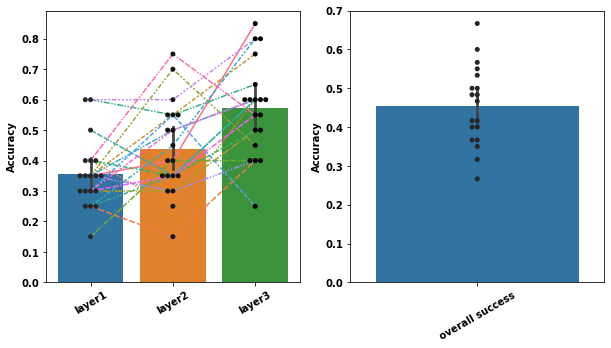

In [61]:
import seaborn as sns
#supress annoying setting on copy warrning: 
pd.options.mode.chained_assignment = None  # default='warn'
final_participants_df['overall_performence']=final_participants_df[['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']].sum(axis=1)/60


fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']]/20,ax=axes[0])
sns.swarmplot(data=final_participants_df[['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']]/20,ax=axes[0],palette='dark:k')
sns.lineplot(data=final_participants_df[['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']].T/20,ax=axes[0],legend=False)

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['overall_performence']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['overall_performence']],ax=axes[1],palette='dark:k')
axes[1].set_xticklabels(labels=['overall success'],rotation=30)
axes[1].set_ylabel('Accuracy')

fig.savefig(PATH_TO_OUTPUTS / 'accuracy per grouping layer.svg',format='svg')
fig.savefig(PATH_TO_OUTPUTS / 'accuracy per grouping layer.jpg',format='jpg')

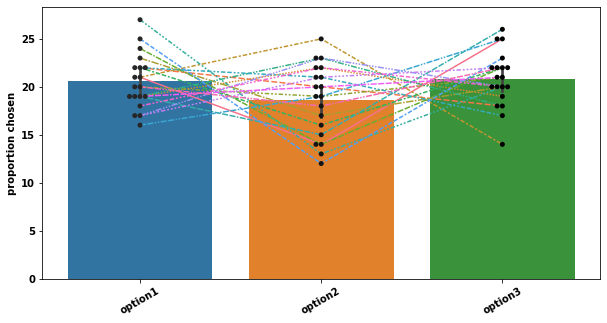

In [62]:
#plot a graph of option selection - to check if biases in responses is apparent: 
#supress annoying setting on copy warrning: 
pd.options.mode.chained_assignment = None  # default='warn'

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(10,5))
sns.barplot(data=final_participants_df[['responses_count_option_1','responses_count_option_2','responses_count_option_3']],ax=axes)
sns.swarmplot(data=final_participants_df[['responses_count_option_1','responses_count_option_2','responses_count_option_3']],ax=axes,palette='dark:k')
sns.lineplot(data=final_participants_df[['responses_count_option_1','responses_count_option_2','responses_count_option_3']].T,ax=axes,legend=False)

axes.set_xticklabels(labels=['option1','option2','option3'],rotation=30)
axes.set_ylabel('proportion chosen')

fig.savefig(PATH_TO_OUTPUTS / 'response bias per location.svg',format='svg')
fig.savefig(PATH_TO_OUTPUTS / 'response bias per location.jpg',format='jpg')

In [63]:
#run some statistical checks: 
import pingouin as pg
from scipy.stats import binomtest
#supress annoying setting on copy warrning: 
pd.options.mode.chained_assignment = None  # default='warn'

pg.rm_anova(data=final_participants_df.loc[:,['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']])

valid_participants_pvals=[]
for cur_overall in final_participants_df['overall_performence']:
    cur_overall=int(cur_overall*60)
    result = binomtest(cur_overall, n=60, p=1/3, alternative='greater')
    #print(f'{cur_overall}/{60}, p = {result.pvalue}')
    valid_participants_pvals.append(result.pvalue)

final_participants_df.loc[:,'overall_binom_pval']=valid_participants_pvals
final_participants_df.loc[:,'is_significant']=final_participants_df.loc[:,'overall_binom_pval']<=0.05
final_participants_df.loc[:,['overall_performence','overall_binom_pval','is_significant']]

num_sig_participants=final_participants_df['is_significant'].sum()
print(f'num participants that are significant: {num_sig_participants} out of {len(final_participants_df)} qualified participants')

#set back to show warrnings for other cells
pd.options.mode.chained_assignment = 'warn'  # default='warn'


num participants that are significant: 10 out of 19 qualified participants


In [67]:
pg.ttest(final_participants_df['overall_performence'],1/3)
df_ttests=pd.DataFrame()
for curcol in ['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']:
    ttest_df=pg.ttest(final_participants_df[curcol]/20,1/3)
    ttest_df['layer']='_'.join(curcol.split('_')[0:2])
    df_ttests=pd.concat([df_ttests,ttest_df],axis=0)
df_ttests    


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,layer
T-test,0.837532,18,two-sided,0.413277,"[0.3, 0.41]",0.192143,0.324,0.124673,layer_1
T-test,3.000717,18,two-sided,0.007673,"[0.37, 0.51]",0.688412,6.488,0.809891,layer_2
T-test,6.615662,18,two-sided,0.000003,"[0.5, 0.65]",1.517737,6070.482,0.999990,layer_3


In [77]:
for curcol in ['layer_1_correct_count','layer_2_correct_count','layer_3_correct_count']:    
    print(f'{curcol}: in proportions\n{final_participants_df[curcol].values/20}')

layer_1_correct_count: in proportions
[0.35 0.25 0.4  0.35 0.3  0.35 0.15 0.4  0.6  0.25 0.5  0.25 0.35 0.3
 0.35 0.6  0.3  0.3  0.4 ]
layer_2_correct_count: in proportions
[0.4  0.15 0.25 0.55 0.3  0.7  0.4  0.35 0.55 0.35 0.35 0.45 0.5  0.55
 0.3  0.6  0.35 0.5  0.75]
layer_3_correct_count: in proportions
[0.85 0.4  0.6  0.75 0.5  0.45 0.4  0.5  0.65 0.6  0.6  0.8  0.6  0.25
 0.4  0.8  0.55 0.6  0.55]
